##1: Setting the Environment

In [5]:
#@title 1.1: Mounting Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#@title 1.2: Setting a folder as working directory
#%cd /content/drive/My Drive/Sentiment Analysis Using LSTM
#!ls

In [34]:
#@title 1.3: Pre-installs
#!pip install keras
#!pip install pandas
#!pip install nltk
#!pip install tensorflow
#!pip install scikit-learn
#!pip install seaborn

#!pip install tensorflow==2.7.0
#!pip install keras==2.7.0

In [10]:
#@title 1.4: Importing libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

#For 2.4 Distribution of upvote ratio and score
import seaborn as sns

##2: Loading The Dataset

In [40]:
#@title 2.1: Importing the Reddit Comments Dataset
reddit_comments = pd.read_csv("depression_dataset_reddit_cleaned.csv")

In [12]:
#@title 2.2: Dataset Exploration

print("Reddit Dataset Shape: " + str(reddit_comments.shape))

print("Reddit Dataset Heading")
reddit_comments.head(5)

Reddit Dataset Shape: (7731, 2)
Reddit Dataset Heading


clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1

In [13]:
#@title 2.3: Checking for slicing values

reddit_comments.isnull().values.any()

False

In the first Iteration, there were null values. To check for and remove null (or missing) values from a DataFrame in Python, particularly if you're using pandas, you can follow these steps:

1. **Check for Null Values**:
   ```python
   reddit_comments.isnull().values.any()
   ```
   This line of code checks if there are any null values in the DataFrame `reddit_comments`. If it returns `True`, it means there are null values present in the DataFrame; otherwise, it returns `False`.

2. **Remove Null Values**:
   You have a few options to handle null values. You can either drop rows containing null values or fill them with appropriate values based on your use case.

   - To remove rows with null values, you can use the `dropna()` method:
     ```python
     reddit_comments.dropna(inplace=True)
     ```

   - Alternatively, you can fill null values with specific values using the `fillna()` method:
     ```python
     # Fill null values with a specific value, for example, 0
     reddit_comments.fillna(0, inplace=True)
     ```

   - Another option is to interpolate the null values with nearby values:
     ```python
     reddit_comments.interpolate(inplace=True)
     ```

   Choose the appropriate method based on your data and analysis requirements. `inplace=True` ensures that the changes are made directly to the original DataFrame.

3. **Verify Removal**:
   After performing the removal or filling operation, you can recheck if any null values remain in the DataFrame:
   ```python
   reddit_comments.isnull().values.any()
   ```
   If it returns `False`, it means you have successfully handled the null values.

Remember to handle null values based on the specific requirements and characteristics of your dataset. Depending on your analysis, dropping null values may lead to data loss, so it's essential to consider alternative strategies such as imputation or interpolation when appropriate.

I chose :
```python     
reddit_comments.dropna(inplace=True)
```

In [26]:
#@title 2.3.1: Dropping Null values if 2.3 returns True
#reddit_comments.dropna(inplace=True)

<Axes: xlabel='is_depression', ylabel='count'>

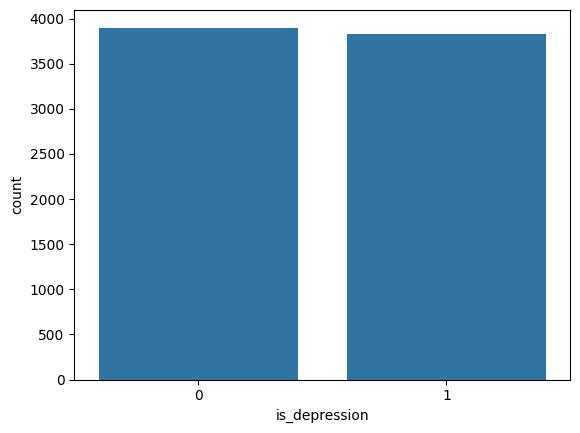

In [14]:
#@title 2.4.1 Distribution of is_depression ratio

sns.countplot(x='is_depression', data = reddit_comments)

## 3: Data Preprocessing

In [15]:
#@title 3.1.1: Analyse comments for preprocessing

reddit_comments["clean_text"][5]

'i m year old turning soon in a few month i live in constant dread i have no passion no goal no special achievement in my life and never been in a relationship i don t know what i want nor what i m doing in this so called life everything just feel exhausting i cry myself to sleep everyday i also feel extremely disconnected from others i don t fit in even though i try the hardest to be a decent human being i try to treat others with kindness and respect be a good listener help people when they need my help work hard exercise on daily basis take a good care of my appearance but no matter how hard i try to present myself at best i still feel i don t fit in i still feel empty unworthy and unwanted i want to do something that i could be proud of but no matter what i do i still never feel i m good enough even for myself i crave for meaningful connection i want to have someone to share and spend my day with laugh with cry with share my handmade gift with just to see smile on their face someon

There is not much to preprocess, so we can remove stopwords through nltk, punctuations and numbers, single characters and multiple spaces

In [16]:
#@title 3.1.2: Download Stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
#@title 3.1.3: Preprocess the comments data

def preprocess_text(sen):
  sentence = sen.lower()

  #remove punctuations and numbers

  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  #remove single characters
  sentence = re.sub(r"\s+[a-zA-Z]\s", ' ',sentence)

  #remove multiple spaces
  sentence = re.sub(r'\s+', ' ',sentence)

  #remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sentence = pattern.sub('', sentence)

  return sentence


In [20]:
#@title 3.1.4: Calling preprocess_text function on movie_reviews

preprocessed_comments = []
sentences = reddit_comments['clean_text']
for sen in sentences:
  preprocessed_comments.append(preprocess_text(sen))

In [21]:
#@title 3.1.5: Sample Cleaned Up Comments

print(preprocessed_comments[5])

year old turning soon month live constant dread passion goal special achievement life never relationship know want called life everything feel exhausting cry sleep everyday also feel extremely disconnected others fit even though try hardest decent human try treat others kindness respect good listener help people need help work hard exercise daily basis take good care appearance matter hard try present best still feel fit still feel empty unworthy unwanted want something could proud matter still never feel good enough even crave meaningful connection want someone share spend day laugh cry share handmade gift see smile face someone feel like home feeling homeless time want feel loved cared wanted like idea meaningful connection head even barely hold conversation whenever try talk someone feel extremely drained stuck rabbit hole feeling extremely lonely energy talk time know feel like failure human want completely disappear thanks reading long rant anywhere else get mind 


In [22]:
y = reddit_comments['clean_text']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [23]:
#@title 3.2 Splitting Dataset into 80-20 dataset

X_train, X_test, y_train, y_test = train_test_split(preprocessed_comments, y, test_size=0.20, random_state=42)

##4: Preparing Embedded Layer

In [24]:
#@title 4.1: Embedding Layer words in numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [25]:
#@title 4.2: Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

16598

In [26]:
#@title 4.3: Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [39]:
#@title 4.4: Load GloVe word embeddings and create as Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records=line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [42]:
#@title 4.5: Embedding Matrix with 100 columns

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [29]:
#@title 4.6: Output
embedding_matrix.shape

(16598, 100)

##5: Model Training

###5.1: Simple Neural Network

In [44]:
#@title 5.1.1: Recurrent Neural Network (LSTM)

from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable = False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.51124001,  0.58787   ,  0.89849001, ..., -0.49353999,
        -0.12878001, -0.45763999],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       ...,
       [-0.1803    ,  0.38202   ,  0.11089   , ..., -0.2432    ,
        -0.19588999,  0.42704999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])], 'input_length': 100}

In [47]:
#@title 5.1.2: Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
#@title: 5.1.3 Model Training

import numpy as np
X_train = np.array(X_train)
y_train = np.array(y_train)

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - acc: 0.8997 - loss: 0.2099 - val_acc: 1.0000 - val_loss: 2.4778e-05
Epoch 2/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 1.0000 - loss: 2.1931e-05 - val_acc: 1.0000 - val_loss: 1.7241e-05
Epoch 3/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - acc: 1.0000 - loss: 1.6721e-05 - val_acc: 1.0000 - val_loss: 1.4958e-05
Epoch 4/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - acc: 1.0000 - loss: 1.4605e-05 - val_acc: 1.0000 - val_loss: 1.3101e-05
Epoch 5/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - acc: 1.0000 - loss: 1.2958e-05 - val_acc: 1.0000 - val_loss: 1.1523e-05
Epoch 6/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - acc: 1.0000 - loss: 1.1466e-05 - val_acc: 1.0000 - val_loss: 1.0190e-05


In [31]:
#@title 5.1.4: Predictions on the Test Set

import numpy as np

# Convert X_test and y_test to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

score = lstm_model.evaluate(X_test, y_test, verbose=1)

49/49 [==============================] - 4s 83ms/step - loss: 0.0010 - acc: 0.9994


In [32]:
#@title 5.1.5: Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.001016873400658369
Test Accuracy: 0.9993535876274109


## 6: Acheiving LSTM without LSTM library

In [23]:
#!pip uninstall tensorflow
#!pip install tensorflow

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np

num_units = 128

class CustomLSTM(Layer):
    def __init__(self, num_units):
        super(CustomLSTM, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wf = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bf = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)
        self.Wi = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bi = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)
        self.Wo = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bo = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)
        self.Wc = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bc = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)

    def call(self, inputs):
        states = [tf.zeros((tf.shape(inputs)[0], self.num_units)), tf.zeros((tf.shape(inputs)[0], self.num_units))]  # Initialize states
        for input_t in tf.unstack(inputs, axis=1):
            h, c = states
            combined = tf.concat([input_t, h], axis=1)
            f = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)
            i = tf.sigmoid(tf.matmul(combined, self.Wi) + self.bi)
            o = tf.sigmoid(tf.matmul(combined, self.Wo) + self.bo)
            c_candidate = tf.tanh(tf.matmul(combined, self.Wc) + self.bc)
            c = f * c + i * c_candidate
            h = o * tf.tanh(c)
            states = [h, c]
        return h

# Define model
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(CustomLSTM(num_units))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

batch_size = 128
epochs = 6

#Train
X_train = np.array(X_train)
y_train = np.array(y_train)
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# Convert X_test and y_test to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

score = lstm_model.evaluate(X_test, y_test, verbose=1)

# Print the evaluation score
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_lstm (CustomLSTM)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 566ms/step - acc: 1.0000 - loss: 0.2778 - val_acc: 1.0000 - val_loss: 1.4720e-05
Epoch 2/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 429ms/step - acc: 1.0000 - loss: 1.2966e-05 - val_acc: 1.0000 - val_loss: 1.0629e-05
Epoch 3/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - acc: 1.0000 - loss: 1.0569e-05 - val_acc: 1.0000 - val_loss: 9.8148e-06
Epoch 4/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 525ms/step - acc: 1.0000 - loss: 9.7267e-06 - val_acc: 1.0000 - val_loss: 9.0844e-06
Epoch 5/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - acc: 1.0000 - loss: 8.9899e-06 - val_acc: 1.0000 - val_loss: 8.3516e-06
Epoch 6/6
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step - acc: 1.0000 - loss: 8.3042e-06 - val_acc: 1.0000 - val_loss: 7.6154e-06
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 1.0000 - loss: 7.6788e-06
Test Score: 7.642861419299152e-06
Test Accuracy: 1.0
